
# PART II
## Parameter recovery, model validation, bootstrap

**In this tutorial, we will see how to:**

- Validate the modeling results against experimental data
- Test model recovery
- Use bootstrapping to estimate the uncertainty of fitted model parameters


In [ ]:
# # define the github path and authorization token
# RAW_GITHUB_PATH = 'https://raw.githubusercontent.com/bambschool/BAMB2024/main/1-modeling_101/'

# # define the list of files to be downloaded
# files = ['tutorial_1_lib.py']

# for file in files:
#   !wget -O {file} "{RAW_GITHUB_PATH}{file}"

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import pearsonr
import scipy.optimize as optimize

from tutorial_1_lib import *

C:\Users\niels\AppData\Local\Temp\ipykernel_25036\461079308.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**We use model B to generate fake data and in the following we assume that this is our actual experimental data.**

In [49]:

# generate fake data
n = 2500 # number of trials
stim_values = [-3, -2, -1, -.5, 0,.5, 1, 2, 3] # all possible values of stimulus evidence (i.e. signed stim strength)
# parameters of model B
sigma = 1 # decision noise
Lambda = 0.2 # proportion of lapses
#first generate experimental conditions for each trial
c = np.random.choice(a=['control', 'manipulation'], size=n) # condition
s = np.random.choice(a=stim_values, size=n) #stimulus evidence
#simulate model
r = simulate_modelB(s, c, sigma_d=sigma, Lambda=Lambda)
exp_data = pd.DataFrame({'stimulus': s, 'condition':c, 'response':r})


---
# II.1 Model validation


As a very simple example for model validation, we will fit model A and B to the experimental data and compare how well the best-fitting model fits the psychometric curve.

**Fit model B to the experimental data and show the model result and the psychometric curve.**


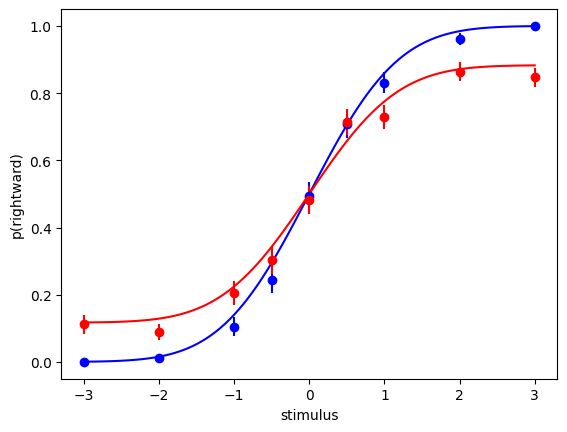

In [3]:

# fit model B
p_opt = optimize.minimize(lambda pp: -LogLikelihood_modelB(exp_data, pp[0], pp[1]), x0=[0.75, 0.1], bounds=[(0.1, 10), (0.01, 1)]).x

# Retrieve the optimized parameters
(sigma_d_hat, Lambda_hat) = p_opt

# plot model predictions
plot_model(lambda s,c: p_modelB(s,c,sigma_d=sigma_d_hat, Lambda=Lambda_hat))

# plot psychometric curve on top
plot_data_psychometric(exp_data)



**Now fit model A to the experimental data and compare to the result obtained above.**


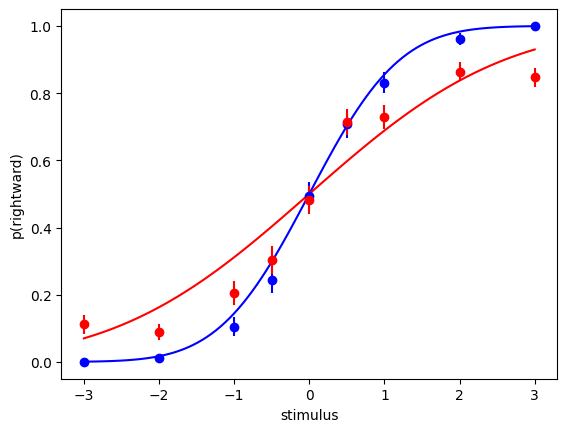

In [7]:
# fit model A
p_opt = optimize.minimize(lambda pp: -LogLikelihood_modelA(exp_data, pp[0], pp[1]), x0=[0.75, 0.1], bounds=[(0.1, 10), (0.1, 10)]).x

# Retrieve the optimized parameters
(sigma_d_hat, sigma_m_hat) = p_opt

# plot model predictions
plot_model(lambda s,c: p_modelA(s,c,sigma_d=sigma_d_hat, sigma_m=sigma_m_hat))

# plot psychometric curve on top
plot_data_psychometric(exp_data)


Fitting the experimental data with model A that does not include lapses but a different $\sigma_m$, we get a worse fit for all the data points and the slope of the fit does not seem right.

Of course, this is trivial here because we now that the "experimental data" actually includes lapses. It is important to note that not including a lapse rate can lead to real-world problems when fitting psychometric functions. We will talk more about this further below.


In general, it is a good idea to show not only that the best-fitting model validates, but that the alternative models do NOT validate (often many models are validated on simple behavioral metrics, and we need of specific patterns of behavior to arbitrate between different models).

---
# II.2. Parameter recovery


## Simulation and fitting

**Simulate Model B to generate synthetic data, then fit these data.**

We will do this step by step. We will first simulate model B using `simulate_modelB` with different random parameters $\sigma_d$ and $\lambda$. Note that the parameter recovery result will depend on the probability distribution used to sample the parameters.

After simulating the model, we will fit the parameters using a maximum likelihood approach to get estimated values $\hat{\sigma_d}$ and $\hat{\lambda}$. 

In [16]:
# loop over at least 100 repetitions
n_rep = 500

# specify parameters of the experiment
n = 2500  # number of trials
stim_values = [-3, -2, -1, -.5, 0,.5, 1, 2, 3]  # all possible values of stimulus evidence (i.e. signed stim strength)

# specify plaubsible range of model parameters
sigma_range = (0.1, 10)
Lambda_range = (0.01, 1) 

pars_gen = np.zeros((n_rep,2))
pars_sim = np.zeros((n_rep,2))
for i in range(n_rep):
        
    # first generate experimental conditions for each trial
    c = np.random.choice(a=['control', 'manipulation'], size=n) # condition
    s = np.random.choice(a=stim_values, size=n) #stimulus evidence

    # simulate model B
    sigma_d = np.random.uniform(sigma_range[0], sigma_range[1])
    Lambda = np.random.uniform(Lambda_range[0], Lambda_range[1])
        
    r = simulate_modelB(s, c, sigma_d=sigma_d, Lambda=Lambda)
    exp_data = pd.DataFrame({'stimulus': s, 'condition':c, 'response':r})
    
    # fit model B
    # Initial guess for parameter set
    x0 = [5, 0.5]

    # Perform the optimization with bounds
    result = optimize.minimize(lambda pp: -LogLikelihood_modelB(exp_data, pp[0], pp[1]), x0=x0, bounds=[sigma_range, Lambda_range])

    # store fitted parameters
    pars_sim[i,0] = result.x[0]
    pars_sim[i,1] = result.x[1]
    
    # Store generating parameters
    pars_gen[i,0] = sigma_d
    pars_gen[i,1] = Lambda


## Parameter recovery plots

We would like to visualise the fitted parameter values as a function of the generating parameter values. We will have one data point for each iteration. Here, you should use the generating values and the fitted values that you have stored in the section above. You should create two subplots, one for each parameter. Do you observe a fairly good agreement between the simulated and fit parameter values?

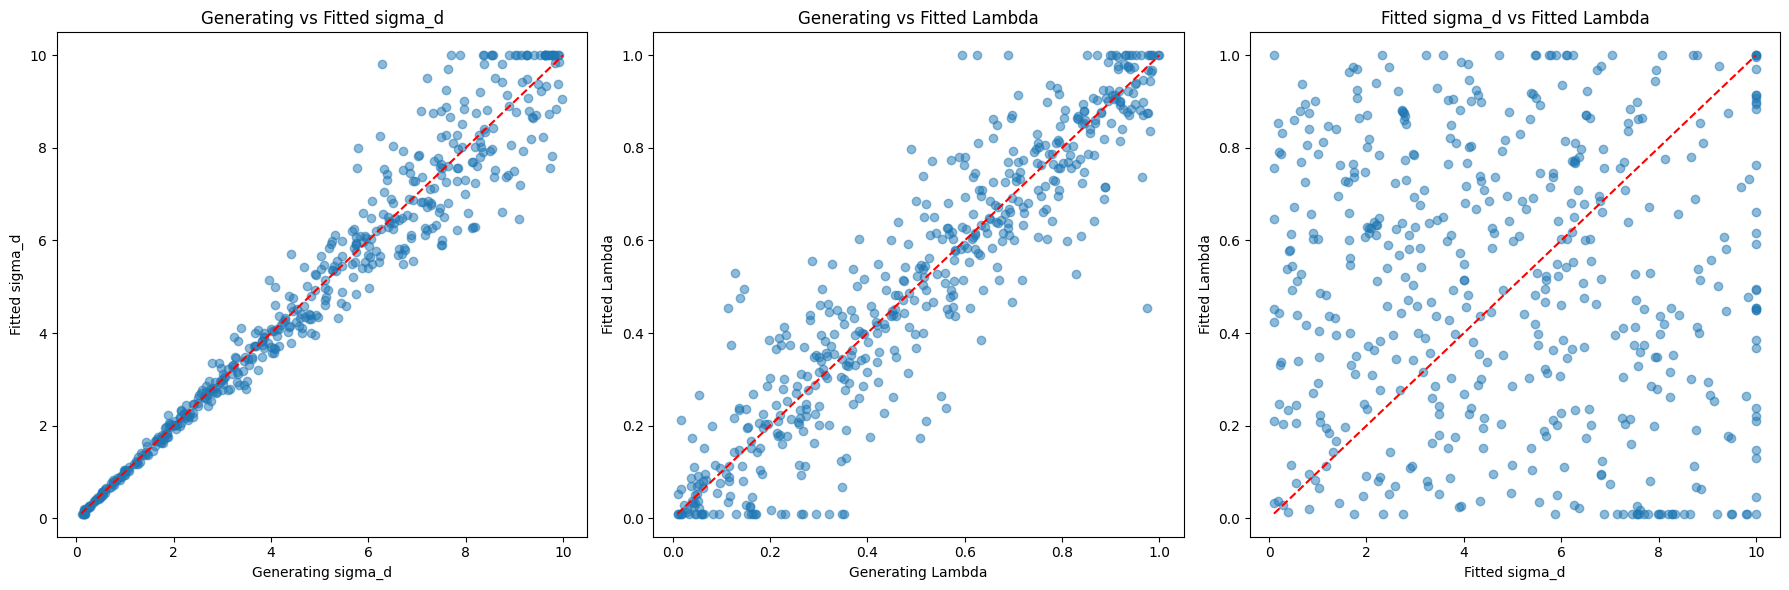

In [18]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for sigma_d
axs[0].scatter(pars_gen[:, 0], pars_sim[:, 0], alpha=0.5)
axs[0].plot([sigma_range[0], sigma_range[1]], [sigma_range[0], sigma_range[1]], 'r--')
axs[0].set_xlabel('Generating sigma_d')
axs[0].set_ylabel('Fitted sigma_d')
axs[0].set_title('Generating vs Fitted sigma_d')

# Plot for Lambda
axs[1].scatter(pars_gen[:, 1], pars_sim[:, 1], alpha=0.5)
axs[1].plot([Lambda_range[0], Lambda_range[1]], [Lambda_range[0], Lambda_range[1]], 'r--')
axs[1].set_xlabel('Generating Lambda')
axs[1].set_ylabel('Fitted Lambda')
axs[1].set_title('Generating vs Fitted Lambda')

axs[2].scatter(pars_sim[:, 0], pars_sim[:, 1], alpha=0.5)
axs[2].plot([sigma_range[0], sigma_range[1]], [Lambda_range[0], Lambda_range[1]], 'r--')
axs[2].set_xlabel('Fitted sigma_d')
axs[2].set_ylabel('Fitted Lambda')
axs[2].set_title('Fitted sigma_d vs Fitted Lambda')

plt.tight_layout()
plt.show()


These plots show strong correlation between true and fitted paramters and also reveal whether the correlation holds in some parameter regimes but not others. It also reveals any existing bias (e.g. a tendency to recover higher or lower values in average) which does not seem to be the case here.

Depending on the parameter values that we obtain when fitting human behavior, the worse correspondence in some parameter range may or may not be problematic. It is be a good idea to use the range of parameters obtained from fitting the real data to test the quality of recovery within the range that matters. 

Reliable parameter recovery is particularly important for look at inter-individual differences in relation to questionnaire scores or brain data.


 **Optional:** Include a third subplot which shows a scatterplot of the fitted parameters $\sigma$ and $\lambda$. Also compute the correlation between the two parameters. How do you interpret the result?

In [47]:
# Compute the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(pars_sim[:, 0], pars_sim[:, 1])
print(f"Correlation between fitted sigma_d and fitted Lambda: {correlation:.2f}")
print(f"P-value: {p_value:.2e}")





Correlation between fitted sigma_d and fitted Lambda: -0.06
P-value: 2.19e-01


The fitted parameters are not correlated, indicating that our parameters are identifyable (they cannot be trade-off against each other)

---
# II.3 Parameter uncertainty estimation (bootstrap)


[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a widely applicable method to assess confidence/uncertainty about estimated parameters, it was originally [proposed](https://projecteuclid.org/euclid.aos/1176344552) by [Bradley Efron](https://en.wikipedia.org/wiki/Bradley_Efron). The idea is to generate many new synthetic datasets from the initial true dataset by randomly sampling from it, then finding estimators for each one of these new datasets, and finally looking at the distribution of all these estimators to quantify our confidence.

Note that each new resampled datasets will be the same size as our original one, with the new data points sampled with replacement i.e. we can repeat the same data point multiple times. Also note that in practice we need a lot of resampled datasets.

To explore this idea, we will work againg wit the "experimental data" generated above (the DataFrame `exp_data`).


**Generate resampled data and display the psychometric curves for the original and the resampled data.** Repeat this several times to get a feeling for the "randomness", that is how different the resampled data is from the original data.


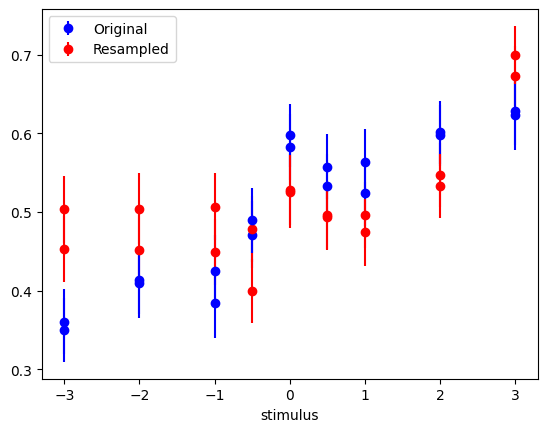

In [39]:

bootstrap_sample = exp_data.sample(n=len(exp_data), replace=True)

# plot psychometric curve
plot_data_psychometric(exp_data)
plot_data_psychometric(bootstrap_sample)
plt.legend(('Original','Resampled'));


## Generate bootstrap estimates

In this exercise you will implement a method to run the bootstrap process of generating a set of fitted parameters from a dataset.


We will do this for model B, that is, we will fit the model B and return an array with the fitted parameters $\sigma_m$ and $\lambda$.


In [50]:
def bootstrap_estimates(data, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.
  Args:
    data (DataFrame)
    n (int): The number of estimates to compute
  Returns:
    ndarray: An array of estimated parameters with size (n,2)
  """

  theta_hats = np.zeros((n,2))

  # Loop over number of estimates
  for i in range(n):

    # Resample data
    bootstrap_sample = exp_data.sample(n=len(exp_data), replace=True)
    
    # Compute theta_hat for this sample
    result = optimize.minimize(lambda pp: -LogLikelihood_modelB(bootstrap_sample, pp[0], pp[1]), x0=[0.75, 0.1], bounds=[(0.1, 10), (0.01, 1)]).x

    theta_hats[i,:] = result

  return theta_hats

# Get bootstrap estimates (generate only 3 bootstrap samples for a quick check if everything works)
theta_hats = bootstrap_estimates(exp_data, n=500)
print(theta_hats)

[[1.12132973 0.17378254]
 [1.05097353 0.22712473]
 [1.11370064 0.15088146]
 [0.99641808 0.18257393]
 [1.05091117 0.19755801]
 [1.02599691 0.21457246]
 [0.91924853 0.2318101 ]
 [1.04252025 0.18342461]
 [1.03295562 0.15702552]
 [1.09457485 0.16759371]
 [0.96813226 0.20807226]
 [1.00951766 0.20208634]
 [0.92650847 0.16878172]
 [1.03459997 0.16832084]
 [1.01352063 0.161894  ]
 [1.01857842 0.1909706 ]
 [1.00055305 0.24429323]
 [1.08569678 0.17519998]
 [1.06187597 0.16282035]
 [1.06560581 0.12886773]
 [0.95629017 0.19081704]
 [1.06848713 0.19276671]
 [1.05758924 0.17052902]
 [1.12621074 0.15116286]
 [0.99658535 0.19469146]
 [0.92121786 0.17498289]
 [1.05769114 0.14743635]
 [1.06775799 0.14698337]
 [0.98506836 0.18060005]
 [1.03758416 0.17077982]
 [0.94056933 0.1644898 ]
 [1.05380278 0.17223564]
 [1.07387323 0.14212111]
 [0.9499214  0.16152645]
 [1.0326249  0.17166525]
 [0.99291858 0.17107045]
 [1.08604157 0.14846231]
 [1.01418094 0.15187876]
 [1.07598292 0.19962628]
 [1.08136857 0.17164485]


## Plot bootstrap samples and confidence intervals

Let us now quantify how uncertain our estimated parameters ($\sigma_m$ and $\lambda$) are. We do so by computing confidence intervals from our bootstrapped estimates. The most direct approach is to compute percentiles from the empirical distribution of bootstrapped estimates. Note that this is widely applicable as we are not assuming that this empirical distribution is Gaussian.


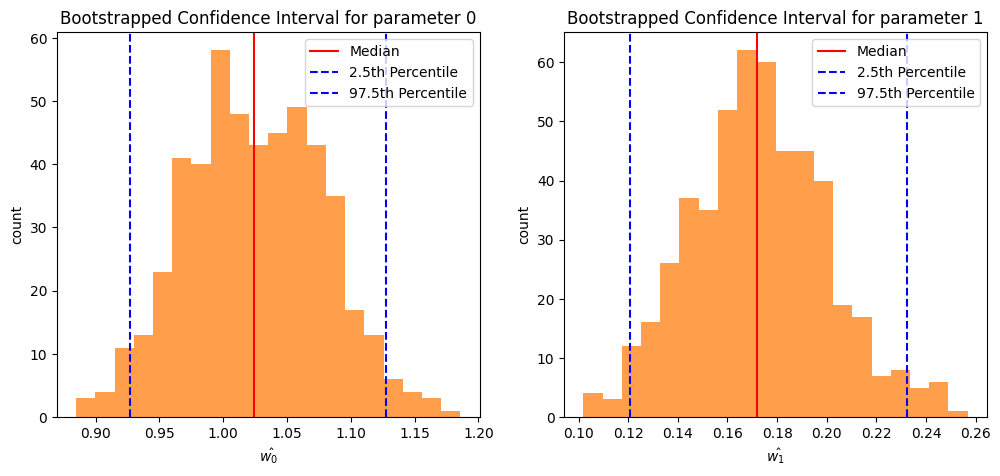

In [51]:

means = np.mean(theta_hats,axis=0)
stds = np.std(theta_hats,axis=0)
medians = np.median(theta_hats,axis=0)  # compute medians
CIs = np.percentile(theta_hats, [2.5, 97.5], axis=0)  # compute 95% confidence intervals

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

for i in range(2):
    ax[i].hist(theta_hats[:,i], bins=20, facecolor='C1', alpha=0.75);
    ax[i].axvline(medians[i], color='r', label='Median')

    # show confidence intervals:
    ax[i].axvline(CIs[0, i], color='b', linestyle='--', label='2.5th Percentile')
    ax[i].axvline(CIs[1, i], color='b', linestyle='--', label='97.5th Percentile')

    
    ax[i].legend()
    ax[i].set(
        title='Bootstrapped Confidence Interval for parameter '+str(i),
        xlabel=r'$\hat{{w_' + str(i) +'}}$',
        ylabel='count');


## Illustrate bootstrap estimates (show fitted psychometric functions)

Now that we have our bootstrap estimates, we can visualize all the potential models (models computed with different resampling) together to see how distributed they are. 

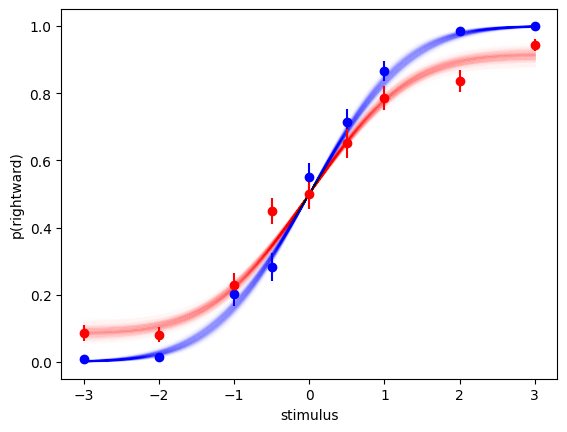

In [53]:

fig, ax = plt.subplots()

# plot all model fits obtained from bootstrap samples
for i, theta_hat in enumerate(theta_hats):
    plot_model(lambda s,c: p_modelB(s,c,sigma_d=theta_hat[0], Lambda=theta_hat[1]))

# make the lines transparant to get a feeling for the distribution of model fits
for line in plt.gca().lines:
    line.set_alpha(0.005)

plot_data_psychometric(exp_data)



## Summary of bootstrapping

- Bootstrapping is a resampling procedure that allows to build confidence intervals around inferred parameter values
- it is a widely applicable and very practical method that relies on computational power and pseudo-random number generators (as opposed to more classical approaches than depend on analytical derivations)
- is non-parametric: the confidence intervals provided by statistical libraries are not always accurate because they assume an underlying gaussian distribution for parameters, which is not always the case.

---
# Optional part: Parameter trade-off between $\lambda$ and $\sigma$


Above we have run a parameter recover analysis for model B that has a fixed $\sigma_c$ across the two experimental condtions, and only $\lambda$ is different between the conditions. Here, we will consider a more interesting example, let's call it model C. In model C, we also allow $\sigma_m$ to change between conditions, that is in the manipulated condition is now described by a $\lambda$ and a $\sigma_m$.

To make the above code direclty reusable, we simplify a bit and only consider "manipulation" trials.

**What do you observe, when using model B to fit the data obtained by model C?**